# **AstrID:**  *model training*

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from astropy.io import fits

# Import custom functions to extract Image arrays and Pixel Mask arrays from our created fits files dataset
from dataGathering import extractImageArray, extractPixelMaskArray, extract_star_catalog
from dataGathering import getStarData, getImagePlot, getPixelMaskPlot
from dataGathering import displayRawImage, displayRawPixelMask, displayImagePlot, displayPixelMaskPlot, displayPixelMaskOverlayPlot

# Import custom functions to preprocess Image and Pixel Mask arrays
from imageProcessing import normalizeImages, stackImages, stackMasks, preprocessImage


2024-11-17 23:24:47.090527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 23:24:47.827214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-11-17 23:24:50.193770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 23:24:50.224921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 23:24:50.225008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available")
    
    # Clear GPU memory
    K.clear_session()
    tf.config.experimental.reset_memory_stats('GPU:0')

GPU is available


2024-11-17 23:24:50.239668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 23:24:50.239937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 23:24:50.240036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 23:24:50.403380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 23:24:50.403494: I tensorflow/compile

### UnSu Unet Object Localization

In [4]:
# Encoder path
    #32 kernels
    #3x3 kernel size
    #padding = same considers edges in the input
# Example function to create a U-Net model
def unet_model(input_shape, filters, kernel_size, activation, padding, initializer):
    inputs = layers.Input(input_shape)

    # Encoder path
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(inputs)
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p1)
    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p2)
    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p3)
    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p4)
    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c5)

    # Decoder path
    u6 = layers.Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding=padding)(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u6)
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c6)

    u7 = layers.Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding=padding)(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u7)
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c7)

    u8 = layers.Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding=padding)(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u8)
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c8)

    u9 = layers.Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding=padding)(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u9)
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

In [5]:
# getStarData('II/246', 250, 'data')

In [6]:
# Create images and masks arrays lists
images = []
masks = []

# Create df to store the star data inside each fits file
star_data = []

# Create a list of all the fits files in the dataset folder
fits_files = os.listdir('data/fits/')

# For all the fits files in the dataset folder specified in file_path, extract the image and mask arrays to the respective lists
file_path = 'data/fits/'
# for file in os.listdir(file_path):
for file in os.listdir(file_path):
    if file.endswith('.png'):
        os.remove(file_path + file)
    if file.startswith('data') and file.endswith('.fits'):
        images.append(extractImageArray(file_path + file))
        masks.append(extractPixelMaskArray(file_path + file))
        star_data.append(extract_star_catalog(file_path + file))

        print(file + ' added to dataset')

data47.fits added to dataset
data8.fits added to dataset
data93.fits added to dataset
data202.fits added to dataset
data79.fits added to dataset
data116.fits added to dataset
data187.fits added to dataset
data100.fits added to dataset
data10.fits added to dataset
data91.fits added to dataset
data34.fits added to dataset
data117.fits added to dataset
data148.fits added to dataset
data107.fits added to dataset
data38.fits added to dataset
data134.fits added to dataset
data238.fits added to dataset
data136.fits added to dataset
data5.fits added to dataset
data189.fits added to dataset
data33.fits added to dataset
data223.fits added to dataset
data162.fits added to dataset
data13.fits added to dataset
data28.fits added to dataset
data208.fits added to dataset
data118.fits added to dataset
data197.fits added to dataset
data143.fits added to dataset
data178.fits added to dataset
data102.fits added to dataset
data200.fits added to dataset
data129.fits added to dataset
data174.fits added to da

# Prepare the data for training

### Convert to 3-Channel Images

The images we have are 512 x 512 pixels, but our model requires them to be in the shape `(512, 512, 3)`, similar to standard RGB images. To achieve this, we stack the single-channel images along the last axis three times, converting them into 3-channel images. This transformation is necessary because the model typically expects 3-channel input images.

For the masks, the model expects them to be in the shape `(512, 512, 1)`. Therefore, we expand the masks along the last axis to add a new dimension, ensuring they have the correct shape.

Additionally, both the images and masks need to be converted to NumPy arrays, as this is the desired format for the training model. Below, we perform these conversions to ensure the data is in the correct format for training.

Notice when displaying the shape of the `train_images` list below we see it is an array of 250 images of the shape mentioned above, giving us a shape `(250, 512, 512, 3)`

In [7]:
stacked_images = stackImages(images)
stacked_masks = stackMasks(masks)
print("masks:")
stacked_masks.shape
print("images")
stacked_images.shape

masks:
images


(250, 512, 512, 3)

### Normalize the Images

To standardize the pixel values in our images, we need to normalize them to a common range.
We will use min-max normalization to scale the pixel values to a range between 0.0 and 1.0.

In [8]:
# stacked_images = normalizeImages(stacked_images)

###  Prepare the model for training


In [9]:
#ryans attempt at weighted cross entropy

@keras.saving.register_keras_serializable()
def weighted_binary_crossentropy(weights):
    """
    Custom loss function for binary cross-entropy with class weights.
    Args:
    - weights: A list or tuple of weights, where:
        - weights[0] is the weight for the background class (class 0)
        - weights[1] is the weight for the foreground class (class 1)
    """
    def loss(y_true, y_pred):
        # Convert inputs to float32 for numerical stability
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Ensure y_true and y_pred have the same shape
        if len(y_true.shape) != len(y_pred.shape):
            y_true = tf.expand_dims(y_true, axis=-1)
        
        # Clip prediction values to avoid log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        
        # Compute binary cross-entropy manually to maintain tensor shapes
        bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        
        # Create weight map with same shape as input
        weight_map = y_true * weights[1] + (1 - y_true) * weights[0]
        
        # Ensure weight_map has the same shape as bce for multiplication
        if weight_map.shape != bce.shape:
            weight_map = tf.broadcast_to(weight_map, bce.shape)
            
        # Apply the weight map to the binary cross-entropy loss
        weighted_bce = weight_map * bce
        
        # Return the mean of the weighted binary cross-entropy
        return tf.reduce_mean(weighted_bce)
    
    return loss



In [10]:
class_weights = [5.0, 1.0]

In [11]:
#############################################

# Define the base exponent - Change this number to increase or decrease the number of filters by a power of 2
base_exponent = 5
#############################################
# base_exponent = 5, so filters result in [32, 64, 128, 256, 512], this was the original value
# base_exponent = 6, so filters result in [64, 128, 256, 512, 1024]
# base_exponent = 7, so filters result in [128, 256, 512, 1024, 2048]
# base_exponent = 8, so filters result in [256, 512, 1024, 2048, 4096]
# base_exponent = 9, so filters result in [512, 1024, 2048, 4096, 8192]
# base_exponent = 10, so filters result in [1024, 2048, 4096, 8192, 16384]

# Generate the filters based on powers of 2
filters = [2 ** (base_exponent + i) for i in range(5)]
#############################################
# This list comprehension generates the filter sizes by raising 2 to the powers starting from the base exponent and increasing by 1 for each subsequent filter.
#############################################

# Define hyperparameters
hyperparameters = {
    'input_shape': (512, 512, 3),
    'filters': filters,
    'kernel_size': (3, 3),
    'activation': 'relu',
    'padding': 'same',
    # 'initializer': he_uniform(),
    'initializer': he_uniform,
    'optimizer': 'adam',
    # 'loss': weightedBinaryCrossEntropy,
    'loss': 'binary_crossentropy',
    #'weights' : {0 : 1.0, 1 : 5.0},
    'weights': class_weights,
    'metrics': ['accuracy'],
    'epochs': 100,
    'batch_size': 4,
    'early_stopping_patience': 10,
    'test_size': 0.2,
    'random_state': 0,
    'seed': 42
}
#ryans attempt at defining weights
class_weights = [hyperparameters['weights'][0], hyperparameters['weights'][1]]

# Create and compile the model using hyperparameters
model = unet_model(
    input_shape=hyperparameters['input_shape'],
    filters=hyperparameters['filters'],
    kernel_size=hyperparameters['kernel_size'],
    activation=hyperparameters['activation'],
    padding=hyperparameters['padding'],
    initializer=hyperparameters['initializer']
)
model.compile(
    optimizer=hyperparameters['optimizer'],
    #loss=hyperparameters['loss'],
    loss=weighted_binary_crossentropy(class_weights),
    metrics=hyperparameters['metrics']
)

**Create Generators for Training and Validation**:
   - Use the `flow` method to create generators for training and validation images and masks.
   - Ensure that the `seed` parameter is the same for both image and mask generators to maintain alignment.

 **Custom Generator**:
   - Define a custom generator function `custom_generator` that yields a tuple (images, masks, sample_weights).

In [12]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(stacked_images, stacked_masks, test_size=hyperparameters['test_size'], random_state=hyperparameters['random_state'])

In [13]:
# Show distribution of training and validation sets
print('Training images: ', train_images.shape)
print('Training masks: ', train_masks.shape)
print('Validation images: ', val_images.shape)
print('Validation masks: ', val_masks.shape)

Training images:  (200, 512, 512, 3)
Training masks:  (200, 512, 512, 1)
Validation images:  (50, 512, 512, 3)
Validation masks:  (50, 512, 512, 1)


# Train the model

In [14]:
from sklearn.utils import class_weight

# Implement Early stopping to cut useless epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric like 'val_accuracy'
    patience=hyperparameters['early_stopping_patience'],         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restores the model to the best state after stopping
)

# Check the shapes of the input data
print("Train Images Shape: ", train_images.shape)  # Should be (batch_size, 512, 512, 3)
print("Train Masks Shape: ", train_masks.shape)  # Should be (batch_size, 512, 512, 1)

# Check the shapes of the validation data
print("Validation Images Shape: ", val_images.shape)  # Should be (batch_size, 512, 512, 3)
print("Validation Masks Shape: ", val_masks.shape)  # Should be (batch_size, 512, 512, 1)


# # Train the model
history = model.fit(
     train_images, train_masks, 
     validation_data=(val_images, val_masks), 
     epochs=hyperparameters['epochs'], 
     batch_size=hyperparameters['batch_size'],
     callbacks=[early_stopping],
 )

Train Images Shape:  (200, 512, 512, 3)
Train Masks Shape:  (200, 512, 512, 1)
Validation Images Shape:  (50, 512, 512, 3)
Validation Masks Shape:  (50, 512, 512, 1)
Epoch 1/100


2024-11-17 23:24:59.339688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-17 23:25:00.624876: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efb42679710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-17 23:25:00.624943: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-11-17 23:25:00.632256: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-17 23:25:00.738384: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 18s 122ms/step - loss: 2.3401 - accuracy: 0.9662 - val_loss: 0.0803 - val_accuracy: 0.9950
Epoch 2/100
50/50 [==============================] - 5s 101ms/step - loss: 0.0915 - accuracy: 0.9943 - val_loss: 0.0803 - val_accuracy: 0.9950
Epoch 3/100
50/50 [==============================] - 5s 101ms/step - loss: 0.0915 - accuracy: 0.9943 - val_loss: 0.0803 - val_accuracy: 0.9950
Epoch 4/100
50/50 [==============================] - 3s 49ms/step - loss: 0.0915 - accuracy: 0.9943 - val_loss: 0.0803 - val_accuracy: 0.9950
Epoch 5/100
50/50 [==============================] - 5s 99ms/step - loss: 0.0915 - accuracy: 0.9943 - val_loss: 0.0803 - val_accuracy: 0.9950
Epoch 6/100
50/50 [==============================] - 5s 100ms/step - loss: 0.0915 - accuracy: 0.9943 - val_loss: 0.0803 - val_accuracy: 0.9950
Epoch 7/100
50/50 [==============================] - 5s 102ms/step - loss: 0.0915 - accuracy: 0.9943 - val_loss: 0.0803 - val_accuracy: 0.9950
Epoch 8/100


In [15]:
# Save the model
saved_models_path = 'models/saved_models/'
training_size = str(len(train_images))
saved_model_name = datetime.datetime.now().strftime("%Y_%m_%d-%H%M_") + training_size + '_unet_model.keras'
model.save(saved_models_path + saved_model_name)

In [16]:
# Show training loss and validation loss
print('Training loss: ', history.history['loss'][-1])
print('Validation loss: ', history.history['val_loss'][-1])

# Show training accuracy and validation accuracy
print('Training accuracy: ', history.history['accuracy'][-1])
print('Validation accuracy: ', history.history['val_accuracy'][-1])

Training loss:  0.09148108214139938
Validation loss:  0.08030083775520325
Training accuracy:  0.9943243265151978
Validation accuracy:  0.9950180053710938


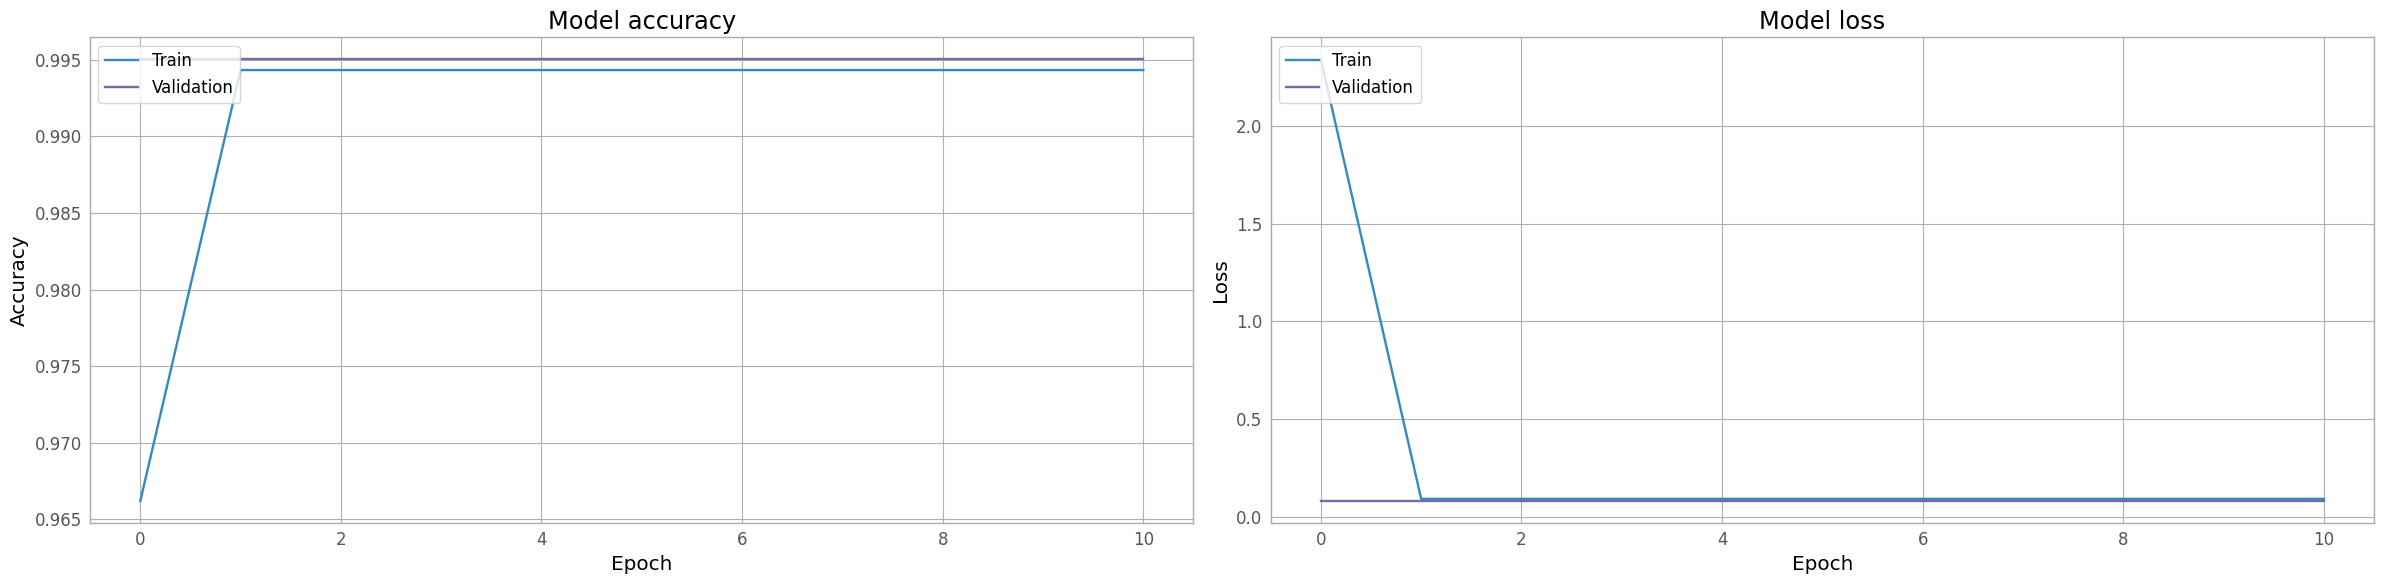

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
# plt.savefig('results/figures/' + saved_model_name.removesuffix('unet_model.keras') + '_training_validation.png')
plt.show()

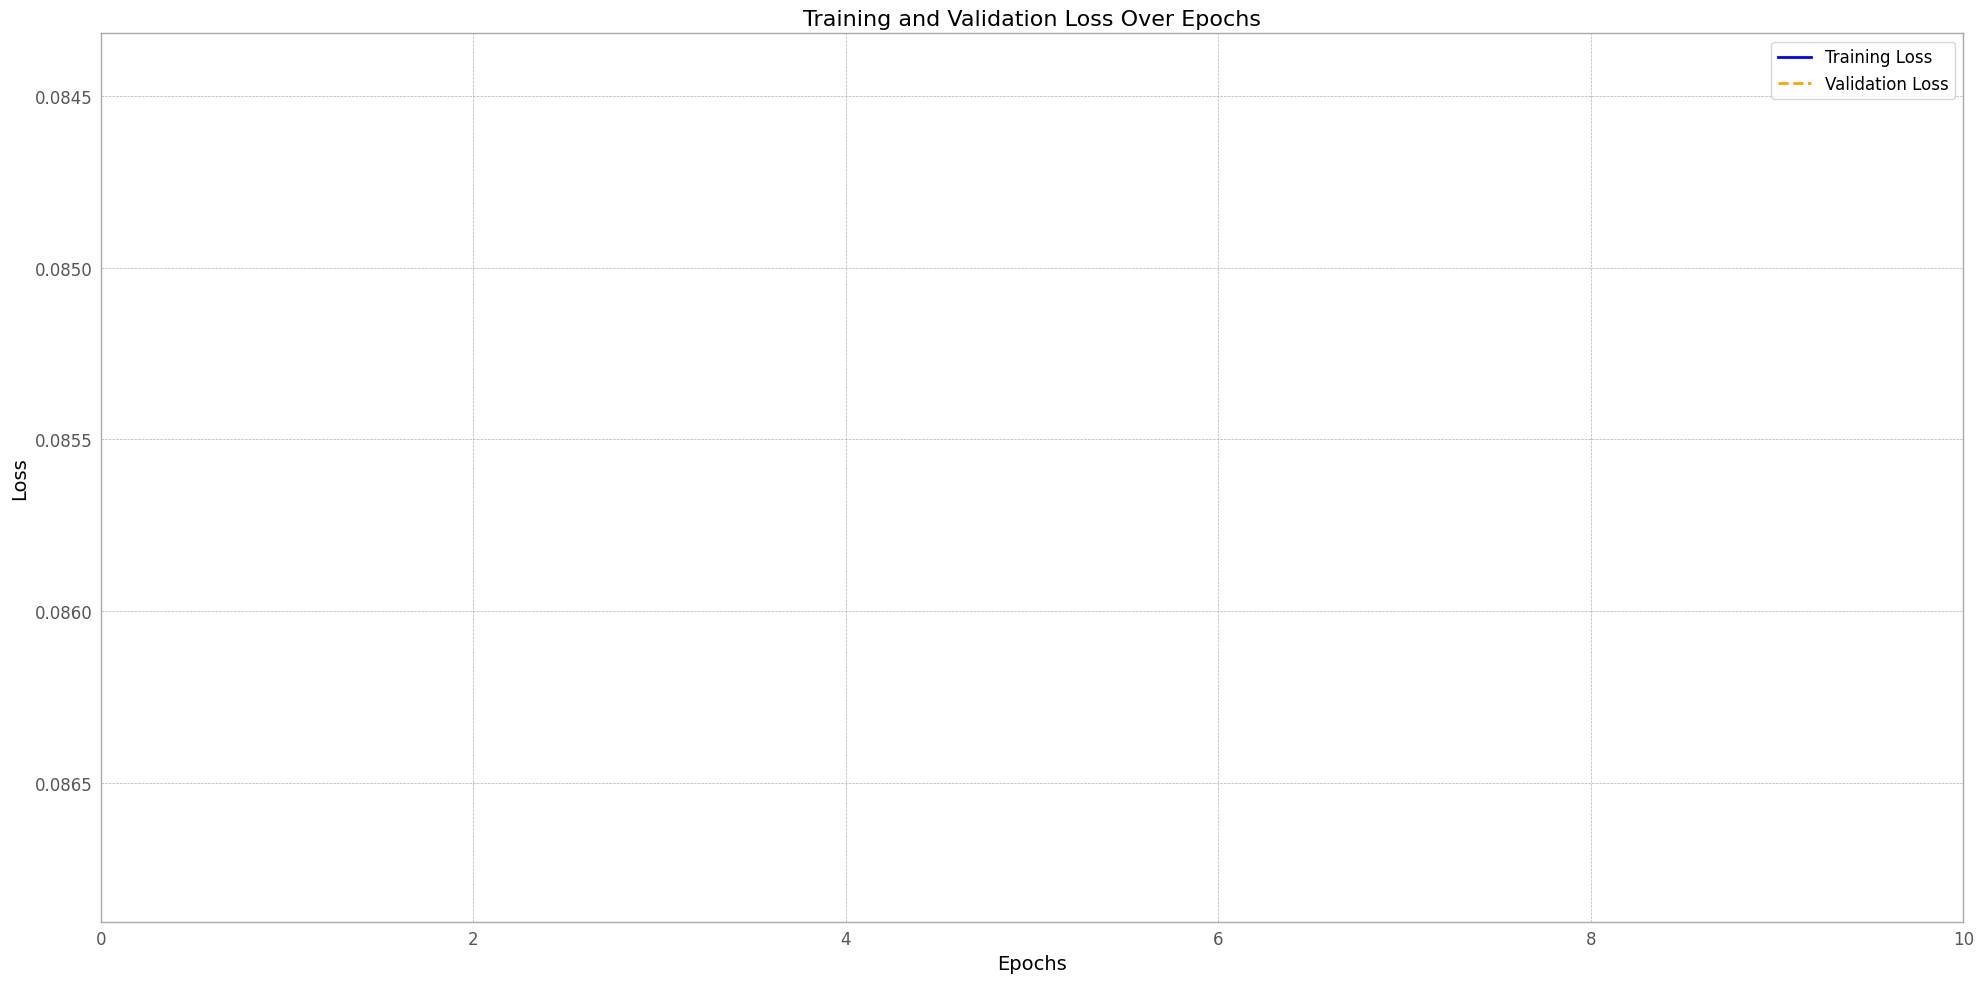

In [18]:
# Set a larger figure size
plt.figure(figsize=(20, 10))

# Plot the training and validation loss
plt.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', linestyle='--', linewidth=2, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend to differentiate between training and validation loss
plt.legend(loc='best', fontsize=12)

# Set limits for better visualization
plt.xlim(0, len(history.history['loss']) - 1)  # From epoch 0 to the last epoch
plt.ylim(min(history.history['loss']) * 0.95, max(history.history['val_loss']) * 1.05)

# Show the plot
plt.tight_layout()
# plt.savefig('results/figures/' + saved_model_name.removesuffix('unet_model.keras') + '_training_validation_loss.png')
plt.show()
